In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import importlib
%matplotlib inline

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from load.load_data import load_opendata
from load.load_data import load_mydata

import utils.process
importlib.reload(utils.process)
from utils.process import preprocess, noise, augment, tsne_plot, display_pair, shuffler, label_dict_static, display_row, score, matching_plot

import model.model_autoencoder
from model.model_autoencoder import multihead_classifier_with_encoder

In [2]:
# Intialize the tensorflow-gpu <-> physical matching
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
fin_multi = load_model("./ckpt/model_encoder_multihead")

In [6]:
fin_multi.summary()

Model: "final_multi"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 8, 8, 256)    1029248     input_layer[0][0]                
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 8, 8, 256)    0           encoder[0][0]                    
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 16384)        0           dropout_8[0][0]                  
________________________________________________________________________________________

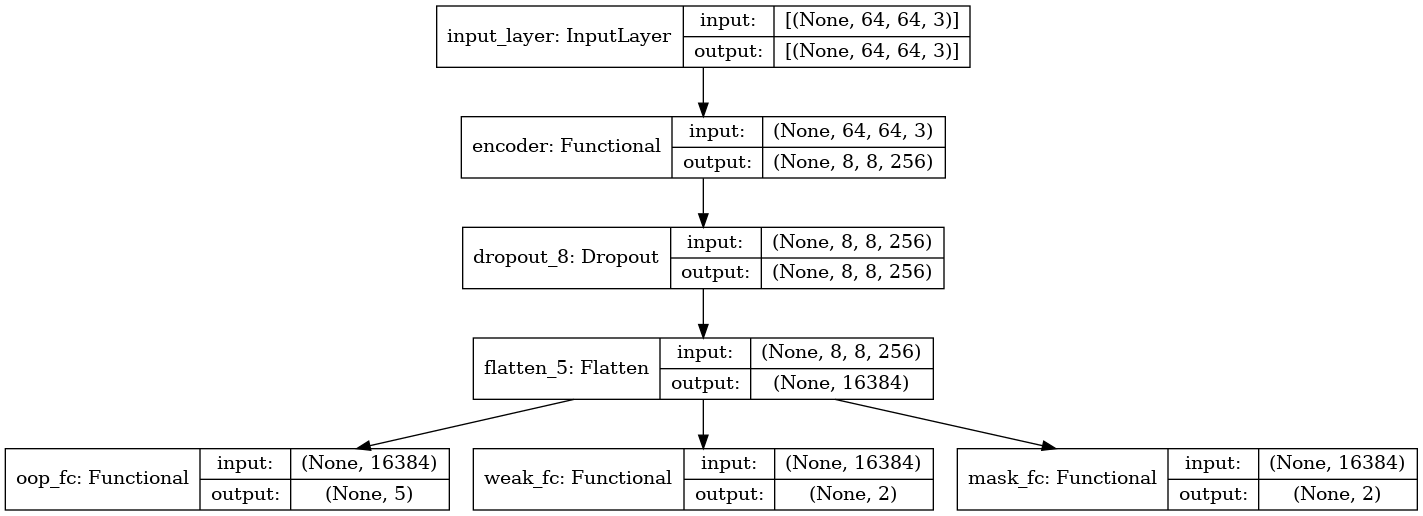

In [7]:
tf.keras.utils.plot_model(fin_multi, show_shapes=True)

In [8]:
## 1. Load & Prepare Data
openloader = load_opendata()
X_open, Y_open = openloader.load_data(classifier_label="OOP", dsize=(64,64), comp_ratio=4)

myloader = load_mydata()
X_my, Y_my = myloader.load_data(classifier_label="OOP", dsize=(64,64), comp_ratio=10, verbose=0)
X_my_test, Y_my_test = myloader.load_test_data(classifier_label="OOP", dsize=(64,64), comp_ratio=4, verbose=0)

print("Open data is ", len(X_open),", My Train set is ", len(Y_my),  ",  My Test set is ", len(Y_my_test))

## 3. Data preprocessing

# Normalized Image
X1 = preprocess(X_my, shape = (64,64,3))
X2 = preprocess(X_open, shape=(64,64,3))
X = np.concatenate((X1, X2), axis=0)
Y = np.concatenate((Y_my, Y_open), axis=0)

X_test_oop = preprocess(X_my_test, shape=(64,64,3))

# Data Augmentation (5%*3=15%)
X, Y = augment(X, labels=Y, ratio=0.05)

# Shuffled Image
X, Y = shuffler(X, Y)

# One-hot encoding
label_map, label_str = label_dict_static(classifier="OOP")
Y = np.array(list(map(lambda x: label_map[x], Y)))
Y = to_categorical(Y)

y_test = np.array(list(map(lambda x: label_map[x], Y_my_test)))
y_test_oop = to_categorical(y_test)

## 4. Split Data in train mode
# Train, Val, Test Split
from sklearn.model_selection import train_test_split
X_train_oop, X_val_oop, y_train_oop, y_val_oop = train_test_split(X, Y, test_size=0.2, stratify=Y) 
print("X_train: {}\ny_train: {}\nX_val: {}\ny_val: {}\nX_test: {}\ny_test: {}".format(X_train_oop.shape, y_train_oop.shape, X_val_oop.shape, y_val_oop.shape, X_test_oop.shape, y_test_oop.shape))

Train opendata with Label(OOP): 100%|██████████| 22424/22424 [00:17<00:00, 1291.43it/s]
Train data Loading with OOP: 24821it [00:05, 4262.86it/s]
Test data Loading with OOP: 2000it [00:02, 876.14it/s] 


Open data is  1695 , My Train set is  1018 ,  My Test set is  347
Augmentation samples are 405
X_train: (2494, 64, 64, 3)
y_train: (2494, 5)
X_val: (624, 64, 64, 3)
y_val: (624, 5)
X_test: (347, 64, 64, 3)
y_test: (347, 5)


In [9]:
myloader = load_mydata()
X_my, Y_my = myloader.load_data(classifier_label="Weak", dsize=(64,64), comp_ratio=4, verbose=0)
X_my_test, Y_my_test = myloader.load_test_data(classifier_label="Weak", dsize=(64,64), comp_ratio=4, verbose=0)

print("My Train set is ", len(Y_my),  ",  My Test set is ", len(Y_my_test))

# Normalized Image
X = preprocess(X_my, shape = (64,64,3))
X_test_weak = preprocess(X_my_test, shape=(64,64,3))

# Data Augmentation (5%*3=15%)
X, Y = augment(X, labels=Y_my, ratio=0.05)

# Shuffled Image
X, Y = shuffler(X, Y)

# One-hot encoding
label_map, label_str = label_dict_static(classifier="Weak")
Y = np.array(list(map(lambda x: label_map[x], Y)))
Y = to_categorical(Y)

y_test = np.array(list(map(lambda x: label_map[x], Y_my_test)))
y_test_weak  = to_categorical(y_test)

X_train_weak , X_val_weak , y_train_weak , y_val_weak  = train_test_split(X, Y, test_size=0.2, stratify=Y) 
print("X_train: {}\ny_train: {}\nX_val: {}\ny_val: {}\nX_test: {}\ny_test: {}".format(X_train_weak.shape, y_train_weak.shape, X_val_weak.shape, y_val_weak.shape, X_test_weak.shape, y_test_weak.shape))

Train data Loading with Weak: 24821it [00:34, 728.90it/s]
Test data Loading with Weak: 2000it [00:02, 710.90it/s]


My Train set is  6227 ,  My Test set is  524
Augmentation samples are 933
X_train: (5728, 64, 64, 3)
y_train: (5728, 2)
X_val: (1432, 64, 64, 3)
y_val: (1432, 2)
X_test: (524, 64, 64, 3)
y_test: (524, 2)


In [10]:
myloader = load_mydata()
X_my, Y_my = myloader.load_data(classifier_label="Mask", dsize=(64,64), comp_ratio=4, verbose=0)
X_my_test, Y_my_test = myloader.load_test_data(classifier_label="Mask", dsize=(64,64), comp_ratio=4, verbose=0)

print("My Train set is ", len(Y_my),  ",  My Test set is ", len(Y_my_test))

# Normalized Image
X = preprocess(X_my, shape = (64,64,3))
X_test_mask = preprocess(X_my_test, shape=(64,64,3))

# Data Augmentation (5%*3=15%)
X, Y = augment(X, labels=Y_my, ratio=0.05)

# Shuffled Image
X, Y = shuffler(X, Y)

# One-hot encoding
label_map, label_str = label_dict_static(classifier="Mask")
Y = np.array(list(map(lambda x: label_map[x], Y)))
Y = to_categorical(Y)

y_test = np.array(list(map(lambda x: label_map[x], Y_my_test)))
y_test_mask  = to_categorical(y_test)

X_train_mask , X_val_mask , y_train_mask , y_val_mask  = train_test_split(X, Y, test_size=0.2, stratify=Y) 
print("X_train: {}\ny_train: {}\nX_val: {}\ny_val: {}\nX_test: {}\ny_test: {}".format(X_train_mask.shape, y_train_mask.shape, X_val_mask.shape, y_val_mask.shape, X_test_mask.shape, y_test_mask.shape))

Train data Loading with Mask: 24821it [00:34, 718.31it/s]
Test data Loading with Mask: 2000it [00:03, 652.25it/s]


My Train set is  6227 ,  My Test set is  524
Augmentation samples are 933
X_train: (5728, 64, 64, 3)
y_train: (5728, 2)
X_val: (1432, 64, 64, 3)
y_val: (1432, 2)
X_test: (524, 64, 64, 3)
y_test: (524, 2)


In [47]:
import utils.xai_viz
from utils.xai_viz import explainable_model
importlib.reload(utils.xai_viz)

xai = explainable_model(fin_multi)

OOP score
Test Predict is: 97.98270893371757%
Weak score
Test Predict is: 100.0%
Mask score
Test Predict is: 97.32824427480917%


Text(0.5, 1.0, 'Predicted: 1 as 7.454,    Label: 1')

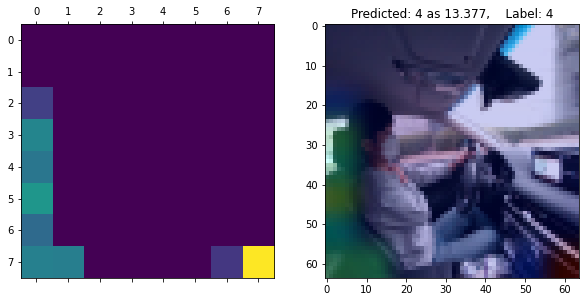

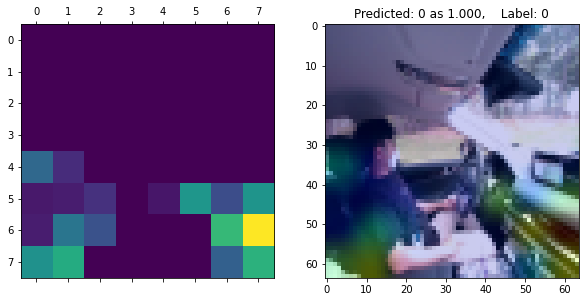

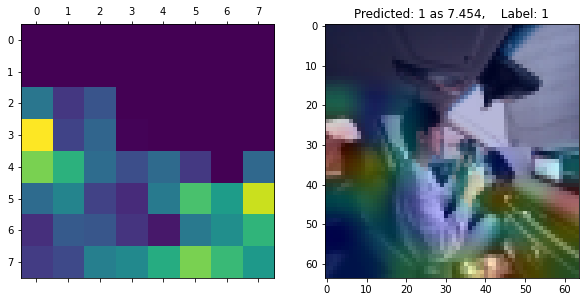

In [56]:
pick = random.randint(0, len(X_test_oop)-1)

X_pred = fin_multi.predict(X_test_oop)
print("OOP score")
score(X_pred[0], y_test_oop)

heatmap = xai.explainable_model(X_test_oop[pick], "dropout_8", alpha=0.4, output_node=0)
fig_title = "Predicted: {} as {:.3f}".format(np.argmax(X_pred[0][pick]), X_pred[0][pick][np.argmax(X_pred[0][pick])])  +   ",    Label: {}".format(np.argmax(y_test_oop[pick]))  
plt.title(fig_title)

pick = random.randint(0, len(X_test_weak)-1)

X_pred = fin_multi.predict(X_test_weak)
print("Weak score")
score(X_pred[1], y_test_weak)

heatmap = xai.explainable_model(X_test_weak[pick], "dropout_8", alpha=0.4, output_node=1)
fig_title = "Predicted: {} as {:.3f}".format(np.argmax(X_pred[1][pick]), X_pred[1][pick][np.argmax(X_pred[1][pick])])  +   ",    Label: {}".format(np.argmax(y_test_weak[pick]))  
plt.title(fig_title)

pick = random.randint(0, len(X_test_mask)-1)

X_pred = fin_multi.predict(X_test_mask)
print("Mask score")
score(X_pred[2], y_test_mask)

heatmap = xai.explainable_model(X_test_mask[pick], "dropout_8", alpha=0.4, output_node=2)
fig_title = "Predicted: {} as {:.3f}".format(np.argmax(X_pred[2][pick]), X_pred[2][pick][np.argmax(X_pred[2][pick])])  +   ",    Label: {}".format(np.argmax(y_test_mask[pick]))  
plt.title(fig_title)